In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

df = pd.read_excel(r'C:\Users\IShop\Desktop\Online Retail.xlsx')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [8]:
customer_df = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique', 'Quantity': 'sum','TotalPrice': 'sum','InvoiceDate': 'max'}).rename(columns={
    'InvoiceNo': 'Order_Freq','Quantity': 'total_quantity','TotalPrice': 'total_spending','InvoiceDate': 'lastorderdate'})

In [15]:
customer_df['Recency'] = (pd.Timestamp.now() - customer_df['lastorderdate']).dt.days
customer_df.drop(columns='lastorderdate', inplace=True)
customer_df

,Order_Freq,total_quantity,total_spending,Recency
CustomerID,,,,
12346.0,1,74215,77183.60,4929
12347.0,7,2458,4310.00,4605
12348.0,4,2341,1797.24,4679
12349.0,1,631,1757.55,4622
12350.0,1,197,334.40,4913
...,...,...,...,...
18280.0,1,45,180.60,4881
18281.0,1,54,80.82,4784
18282.0,2,103,178.05,4611


In [16]:
customer_df=customer_df.astype('float64')
scl = StandardScaler()
scaled_data = scl.fit_transform(customer_df)

pca = PCA()
pca_data = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_
print('Explained variance by each principal component:', explained_variance)

Explained variance by each principal component: [0.6071164  0.24696221 0.12665222 0.01926917]


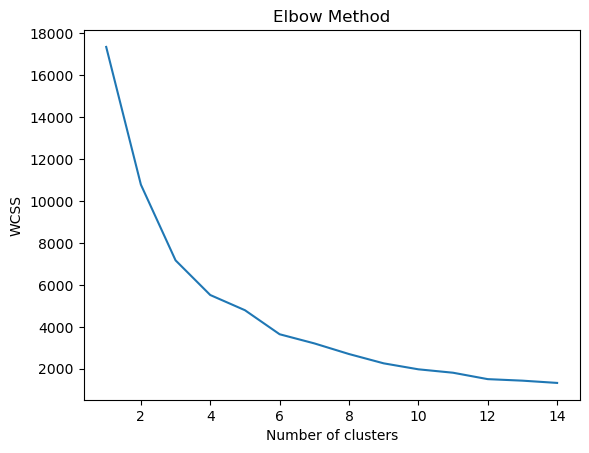

In [20]:
wcss=[]
for i in range (1,15):
    km=KMeans(n_clusters=i,init='k-means++',max_iter=200,random_state=30)
    km.fit(pca_data)
    wcss.append(km.inertia_)
wcss
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
opt_num_of_clusters=4
km=KMeans(n_clusters=opt_num_of_clusters,init='k-means++',max_iter=200,random_state=30)
clusters=km.fit_predict(pca_data)
customer_df['clusters']=clusters
customer_df

,Order_Freq,total_quantity,total_spending,Recency,clusters
CustomerID,,,,,
12346.0,1.0,74215.0,77183.60,4929.0,3
12347.0,7.0,2458.0,4310.00,4605.0,0
12348.0,4.0,2341.0,1797.24,4679.0,0
12349.0,1.0,631.0,1757.55,4622.0,0
12350.0,1.0,197.0,334.40,4913.0,1
...,...,...,...,...,...
18280.0,1.0,45.0,180.60,4881.0,1
18281.0,1.0,54.0,80.82,4784.0,1
18282.0,2.0,103.0,178.05,4611.0,0


In [25]:
clusters_mean=customer_df.groupby('clusters').agg({'Order_Freq':'mean','total_quantity':'mean','total_spending':'mean','Recency':'mean'}).reset_index()
clusters_mean

,clusters,Order_Freq,total_quantity,total_spending,Recency
0,0,4.615193,1037.580946,1779.788974,4644.485679
1,1,1.580349,285.403122,560.342600,4849.402204
2,2,67.166667,94944.666667,195271.033333,4609.333333
3,3,51.096774,30794.516129,45576.981613,4620.032258


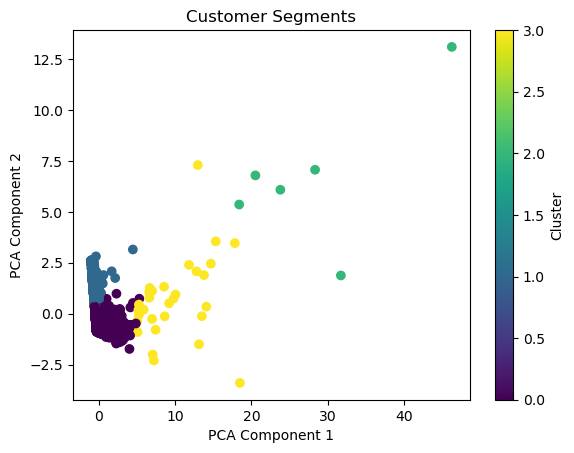

In [26]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments')
plt.colorbar(label='Cluster')
plt.show()

In [27]:
silhouette_avg = silhouette_score(pca_data, clusters)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5829743036455828
